In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision import utils as vutils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 1
workers = 1
image_size = (256, 256)

dataroot = '../images'

dataset_test = datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ],
    ),
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

In [4]:
norm_layer = nn.InstanceNorm2d


class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f),
                                  nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)

    def forward(self, x):
        return F.relu(self.norm(self.conv(x) + x))


class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(3, f, 7, 1, 0), norm_layer(f), nn.ReLU(True),
                  nn.Conv2d(f, 2 * f, 3, 2, 1), norm_layer(2 * f),
                  nn.ReLU(True),
                  nn.Conv2d(2 * f, 4 * f, 3, 2, 1), norm_layer(4 * f),
                  nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4 * f))
        layers.extend([
            nn.ConvTranspose2d(4 * f, 4 * 2 * f, 3, 1, 1), nn.PixelShuffle(2),
            norm_layer(2 * f), nn.ReLU(True),
            nn.ConvTranspose2d(2 * f, 4 * f, 3, 1, 1), nn.PixelShuffle(2),
            norm_layer(f), nn.ReLU(True),
            nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
            nn.Tanh()])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

In [5]:
G_A2B = torch.load('1_G_A2B.pt').to(device)
G_A2B = G_A2B.eval()

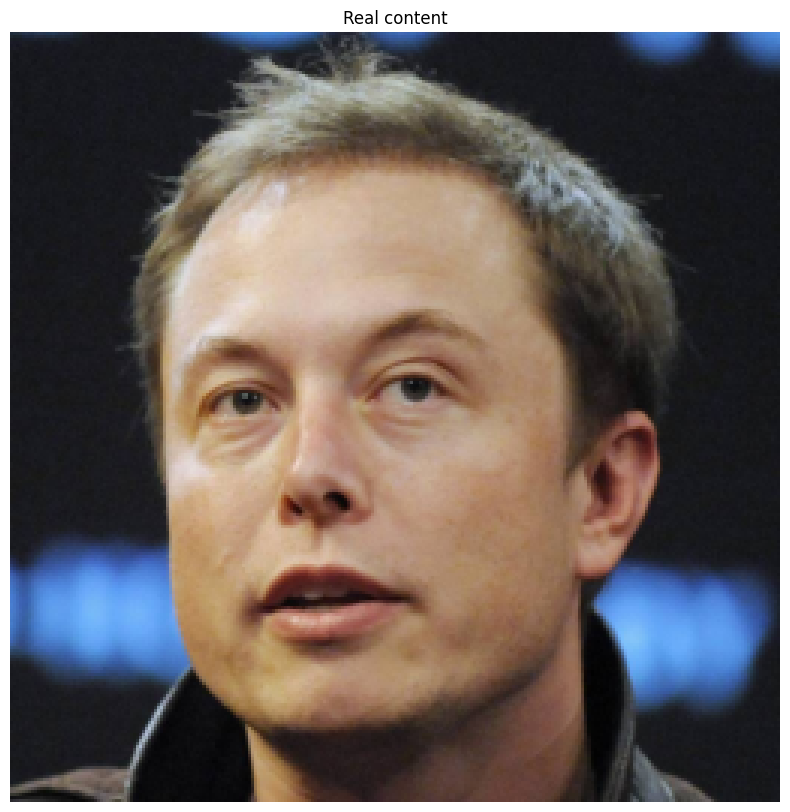

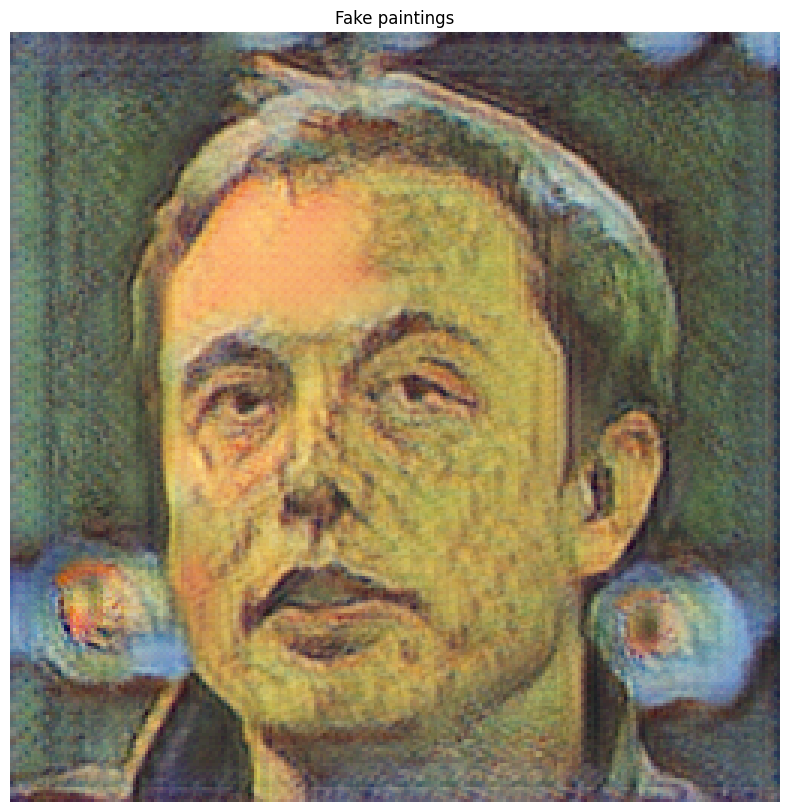

In [6]:
batch_a_test = next(iter(dataset_test))[0].to(device)
real_a_test = batch_a_test.cpu().detach()
fake_b_test = G_A2B(batch_a_test).cpu().detach()

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(
    vutils.make_grid((real_a_test[:4] + 1) / 2, padding=2,
                     normalize=True).cpu(), (1, 2, 0)))
plt.axis('off')
plt.title('Real content')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(
    vutils.make_grid((fake_b_test[:4] + 1) / 2, padding=2,
                     normalize=True).cpu(), (1, 2, 0)))
plt.axis('off')
plt.title('Fake paintings')
plt.show()